wn [  55.11948191  335.85472433  816.94888609  902.92483751 1680.17552106]
omega1 theoretical 52.65920122692874
omega2 theoretical 330.03340000281634
omega3 theoretical 924.1960366599855


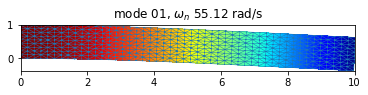

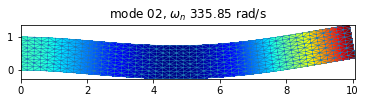

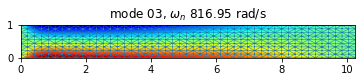

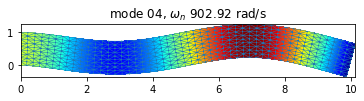

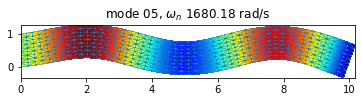

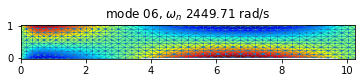

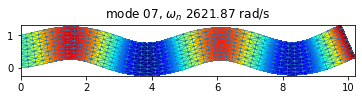

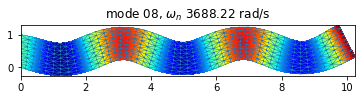

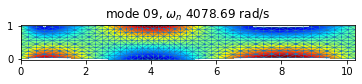

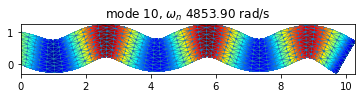

In [33]:
# %load mdof01_generalized_eigenvalue_problem_trias.py
import sys
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import Delaunay
from scipy.linalg import eigh

from tudaesasII.tria3planestress import Tria3PlaneStressIso, update_K_M, DOF

plot_mesh = False
plot_result = True

lumped = False

# number of nodes in each direction
nx = 50
ny = 10

# geometry
L = 10
h = 1
w = h/10
I = h**3*w/12
A = w*h

# material properties
E = 70e9
nu = 0.33
rho = 2.6e3

# creating mesh
xtmp = np.linspace(0, L, nx)
ytmp = np.linspace(0, h, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T

x = ncoords[:, 0]
y = ncoords[:, 1]
nid_pos = dict(zip(np.arange(len(ncoords)), np.arange(len(ncoords))))

# triangulation to establish nodal connectivity
d = Delaunay(ncoords)
if plot_mesh:
    plt.clf()
    ax = plt.gca()
    ax.set_aspect('equal')
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.triplot(ncoords[:, 0], ncoords[:, 1], d.simplices, lw=0.5)
    plt.plot(ncoords[:, 0], ncoords[:, 1], 'o', ms=2)
    plt.show()

#NOTE using dense matrices
K = np.zeros((DOF*nx*ny, DOF*nx*ny))
M = np.zeros((DOF*nx*ny, DOF*nx*ny))

elems = []
# creating tria elements
for s in d.simplices:
    elem = Tria3PlaneStressIso()
    elem.n1 = s[0]
    elem.n2 = s[1]
    elem.n3 = s[2]
    elem.E = E
    elem.nu = nu
    elem.h = h
    elem.rho = rho
    update_K_M(elem, nid_pos, ncoords, K, M, lumped=lumped)
    elems.append(elem)

if lumped:
    assert np.count_nonzero(M-np.diag(np.diagonal(M))) == 0


# applying boundary conditions
bk = np.zeros(K.shape[0], dtype=bool) # defining known DOFs
check = np.isclose(x, 0.)
bk[0::DOF] = check
bk[1::DOF] = check
bu = ~bk # defining unknown DOFs

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]

# solving
# NOTE: extracting ALL eigenvectors
eigvals, U = eigh(a=Kuu, b=Muu)
wn = eigvals**0.5
print('wn', wn[:5])

print('omega1 theoretical', 1.875**2*np.sqrt(E*I/(rho*A*L**4)))
print('omega2 theoretical', 4.694**2*np.sqrt(E*I/(rho*A*L**4)))
print('omega3 theoretical', 7.855**2*np.sqrt(E*I/(rho*A*L**4)))

if plot_result:
    u = np.zeros(K.shape[0], dtype=float)
    for mode in range(10):
        u[bu] = U[:, mode]
        scale = 30
        u1 = scale*u[0::DOF].reshape(nx, ny).T
        u2 = scale*u[1::DOF].reshape(nx, ny).T
        plt.clf()
        plt.title('mode %02d, $\omega_n$ %1.2f rad/s' % (mode+1, wn[mode]))
        plt.gca().set_aspect('equal')
        mag = u2
        levels = np.linspace(mag.min(), mag.max(), 100)
        xplot = xmesh + u1
        yplot = ymesh + u2
        plt.contourf(xplot, yplot, mag, levels=levels, cmap=cm.jet)
        coords_plot = np.vstack((xplot.T.flatten(), yplot.T.flatten())).T
        plt.triplot(coords_plot[:, 0], coords_plot[:, 1], d.simplices, lw=0.5)
        #plt.colorbar()
        plt.show()
        #plt.savefig('plot_truss_mode_%02d.png' % (mode+1), bbox_inches='tight')

